<a href="https://colab.research.google.com/github/nikopetrocelli/489Proj2-Petrocelli/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCE 623 Homework Assignment 3


### Student Name:  <font color="blue">Niko Petrocelli</font>

### Date: <font color="blue">28 Apr 2021 </font>

## Disclosures

*   None

## Overview

In this homework assignment, you will explore various methods of cross-validation. 

We will introduce you to a generated dataset that represents a polynomial function with gaussian noise. You will attempt to fit various models of increasing flexibility (polynomial order) to the data. You will analyze and evaluate each models using cross-validation to (1) determine the model that best fits the data, and (2) predict the performance of your model on new data.

You will then compare the model you developed using machine learning techniques to the model indicated by statistical analysis.

This assignment includes both written and programming components.

### Written Components
Full effort answers to written components should include not only the answer to the question, but they should also include supporting information. You should provide justification or supporting information even if the question only asks for a single number or short answer.

### Programming Components
Use Python to perform any manipulations you make to provided datasets, all calculations and mathematical transformations, and to generate graphs, figures, or other support to explain how you arrived at your written answers.

### Helpful Tips

You might find these Python packages/imports helpful

``` python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

from IPython.display import Markdown as md

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

%matplotlib inline
```

## Cross-fold Validation

### STEP 0: installs & configuration

Install any packages you need for your notebook. If using the Google Colab environment, you will not need to install any additional packages.

In [ ]:
"""
CSCE 623 HW3. Cross-fold Validation
"""
DEBUG = True

# install packages, set configuration, as needed


Import any packages you need for your notebook

In [ ]:
# import pacakages for your notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
 
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
 
from IPython.display import Markdown as md
 
from sklearn.linear_model import LinearRegression

 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import cross_val_score
 
%matplotlib inline


### STEP A: provided functions

In [ ]:
# instructor provided code
plot_x_min = -2.
plot_x_max = 2.

def generate_data(seed = 1, quantity = 200, test_data = False):
    np.random.seed(seed)
    x = np.random.uniform(low=plot_x_min,high=plot_x_max,size=quantity)
    order = np.random.randint(2, 3)
    betas = np.random.uniform(-2, 2, order)

    y = sum((beta * x ** (idx+1) for idx, beta in enumerate(betas)))

    beta0 = np.random.uniform(np.min(y), np.max(y))

    noise = np.random.normal(size=quantity, scale = (np.max(y) - np.min(y)) / 8)
    if test_data: # get new sample if we're generating test data
        noise = np.random.normal(size=quantity, scale = (np.max(y) - np.min(y)) / 8)

    y += noise + beta0

    df = pd.DataFrame({'x': x, 'y': y})

    globals()['global_betas'] = betas
    globals()['global_beta0'] = beta0
    print(order)
    return(df) 

In [ ]:
# instructor provided functions
"""
returns a LaTeX style string representing a function defined by beta0 and betas
"""
def create_model_string(beta0, betas):
    model_function = f'$f(x) = {beta0:.2f}'
    for idx, beta in enumerate(betas):
        model_function += f' + {beta:.2f}x^{idx+1}'
    model_function += '$'
    return model_function

"""
adds a plot of a function to the current plot
"""
def plot_function(x_min, x_max, beta0, betas, resolution = .1, style = None, label = ''):
    plot_x = np.arange(x_min - .2 * abs(x_min), x_max + .2 * abs(x_max), resolution)
    plot_y = sum((beta * plot_x ** (idx+1) for idx, beta in enumerate(betas))) + beta0
    if style:
        plt.plot(plot_x, plot_y, style, label=label)
    else:
        plt.plot(plot_x, plot_y, label=label)



### STEP 1: scikit-learn Functions

Review the scikit-learn documentation for the following functions and answer the questions that follow:

- [User Guide for cross validation iterators](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators)
  - Identically Distributed Data
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
    - [RepeatedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold)
    - [LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html)
    - [LeavePOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html#sklearn.model_selection.LeavePOut)
    - [ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit)
  - Stratification with Class Data
    - [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)
    - [RepeatedStratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html#sklearn.model_selection.RepeatedStratifiedKFold)
    - [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit)
  - Grouped Data
    - [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold)
    - [LeaveOneGroupOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold)
    - [LeavePGroupsOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePGroupsOut.html#sklearn.model_selection.LeavePGroupsOut)
    - [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html#sklearn.model_selection.GroupShuffleSplit)



### Discussion

- Using one of the functions listed above, what is the most straight-forward way to implement "The Validation Set" approach discussed in _ISLR_, 5.1.1 on regression data? What function would you use? What argument values would you use?

  <font color=green class="student_answer">Student Answer</font>

- What function and arguments would you use to implement LOOCV as discussed in _ISLR_ 5.1.2?

  <font color=green class="student_answer">Student Answer</font>

- How would you implement k-fold Cross-Validation as discussedd in _ISLR_ 5.1.3? Assuming $k = 10$, what argument values would you use?

  <font color=green class="student_answer">Student Answer</font>

- If the problem is a classification problem how would you ensure that each _k-fold_ had a balance of classes represented in the data? What function and argument values would you use assuming $k = 10$?

  <font color=green class="student_answer">Student Answer</font>

- Suppose you wanted to train multiple models using k-fold cross-validation each with $k=10$ and compare their performance. What arguments would you use?

  <font color=green class="student_answer">Student Answer</font>



In [ ]:
STEP_1_COMPLETE = False

### Data Analysis

In steps 1-2, you'll load and conduct an analysis of a generated dataset.

#### STEP 2: load dataset

For this assignment, you will use a generated dataset. You have been provided a function that will generate a dataset. You need only provide a random seed value to generate a unique dataset.

You'll initialize a dataset unique to yourself by choosing a random seed value. You can initialize the seed with the last 4 digits of your phone number, your street address, or some other number.

You'll then generate the dataset and store it in a Dataframe named df:
```
df = generate_data(seed)
```

IMPORTANT: After choosing a seed value, you will not want to change this value, as changing the seed will result in your dataset changing. This will invalidate any analysis that you've completed. 


In [ ]:
#STEP 2

#STUDENT CODE - insert code to load a generated dataset using pandas
# store your data in a dataframe called 'df'
#--------------------------------------------- 

df = generate_data(seed=1991)


#---------------------------------------------    

STEP_2_COMPLETE = False

2


#### STEP 3: plot and analyze data

Using a similar approach that you employed in homework assignments 1 and 2, plot and analyze the dataset.


,x,y
count,200.000000,200.000000
mean,-0.091328,4.248316
std,1.150141,1.123814
min,-1.974409,2.016955
25%,-1.127364,3.407675
50%,-0.101311,4.116990
75%,0.932040,4.981013
max,1.952001,7.088062


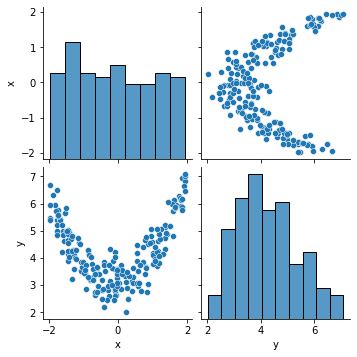

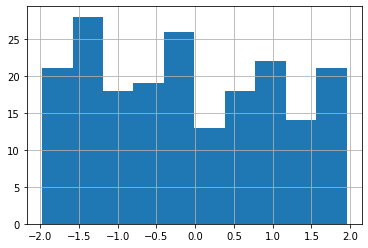

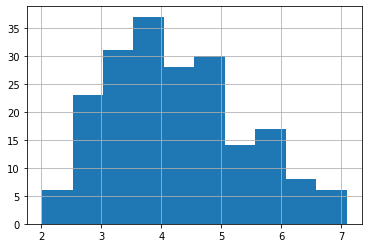

In [ ]:
#STEP 3

#STUDENT CODE - insert code to plot and use pandas analysis tools on the dataset
#---------------------------------------------
display(df.describe())
sns.pairplot(df)
plt.show()
df['x'].hist()
plt.show()
df['y'].hist()
plt.show()

#--------------------------------------------- 

Discuss the dataset, being sure to answer such questions as:
- How many observations are in the dataset?
- How many features?
- What is the nature of the target (regression or classification)?
- What kind of relationship will best fit the data? Linear? Polynomial? If polynomial, what order?
  
  <font color=green class="student_answer">Student Discussion</font>



In [ ]:
STEP_3_COMPLETE = False

#### STEP 4: initial hypothesis

Develop an initial hypothesis about the best model that will fit the data and overlay it on a scatterplot of the dataset. Be sure to use a model informed by your analysis above. I've provided an example below. While my example is quadratic, your model might not necessarily be quadratic. Feel free to use either of the functions provided in SETUP A above.

![initial guess](https://raw.githubusercontent.com/afit-csce623-master/template-hw3/main/images/plot_guess_overlay2.png)

$f(x) = 3.00 + 0.30x^1 + 0.80x^2$


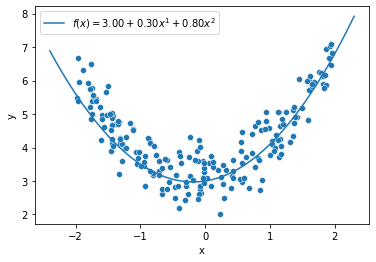

In [ ]:
#STEP 4

#STUDENT CODE - insert code to overlay your initial hypothesis on a scatter plot of the dataset
#---------------------------------------------
sns.scatterplot(x=df['x'],y=df['y'])
betas = [0.3, 0.8]
beta0 = 3
plot_function(plot_x_min, plot_x_max, beta0, betas)
create_model_string(beta0, betas)
print(create_model_string(beta0, betas))
plt.legend(labels=[create_model_string(beta0, betas)])
#---------------------------------------------

STEP_4_COMPLETE = False

### Feature Engineering

In this section, you'll implement code to create a new dataframe with engineered features.

#### STEP 5: feature engineering

`df` contains a feature and a target. You will create a function that will generate a new feature dataframe that will generate a new dataframe with $p$ columns, where column $p$ will contain the the values of $x^p$.

Your function will have the signature `poly_df(x, p)` where `x` is a series of feature values and `p` is the highest order polynomial desired. The function will return a dataframe where the first column contains the original feature values ($x^1$), the second column contains the quadratic values ($x^2$), the third column has cubic values ($x^3$), and so forth. Provide header values of `x^1`, `x^2`, `x^3`, etc.

This is an example of a displayed dataframe returned after calling `poly_df(df.x, 6)` (specific values will differ).

![polynomial dataframe](https://raw.githubusercontent.com/afit-csce623-master/template-hw3/main/images/poly_dataframe.png)

In [ ]:
#STEP 5

#STUDENT CODE - insert code to implement poly_df
#---------------------------------------------
def poly_df(x, p):

  df =  pd.DataFrame()
  for j in range(p):
    df.insert(j,f"x^{j+1} ", 0  )

  
  for i in x:
    vals = []
    for j in range(1, p+1):
      vals.append(np.power(i,j))
      # print(f"i: {i}  -- j: {j} -- i^j: {np.power(i,j)}")
    df.loc[i] = vals


  return df

#---------------------------------------------

# x = np.arange(200)
# df2 = poly_df(x, 4)
# display( df2)
STEP_5_COMPLETE = False

### 3 Ways to Cross Validate

In the following section, we will explore the three methods of cross-validation discussed in the _ISLR_ text:

- Validation Set
- Leave One Out
- K-Fold

For each method, we'll execute three steps:

1. Write a function to calculate the root mean squared error using the intended cross-validation method.
2. Generate a DataFrame of mean-squared error values using the cross-validation technique for models of increasing flexibility. Specifically, you'll evaluate 8 models, polynomial models, ordered 1 through 8.
3. Plot the spaghetti chart of the meand-squared error values



#### SETUP B: constants for cv

Here are constants available for your use in STEPS 6-14

In [ ]:
# instructor provided constants:

# feel free to use throughout the following STEPs

TRIALS = 10
MAX_ORDER = 8
COLUMNS = ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4', 'Trial 5', 'Trial 6', 'Trial 7', 'Trial 8', 'Trial 9', 'Trial 10']
INDICES = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th']


#### Validation Set Approach

In this section, you will evaluate models of increasing flexibility (up to 8th order polynomial) fit to the generated data.

##### STEP 6: validation set rmse

In this step, you'll create `val_set_mse(X, y, random_state)` which returns the root mean squared error of a model fit to a training set and evaluated on a validation set.

- `X` is a DataFrame of feature inputs
- `y` is a Series of targets
- return a scalar value representing the root mean squared error

Hints:
- The instructor's solution to this function uses only 4 lines of code--no Python tricks. If you're using more than 6-8 lines of code, you may not be doing something right
- You'll use the scikit-learn [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to calculate the mean squared error. The use of this function may be a bit non-standard for the typical programmer. While the `X` and `y` arguments are pretty straight-forward, three arguments in particular may be confounding:
  - `estimator` is the model type. Usually, you'll set this in advance and then pass in a reference to the model. For example, if you wanted to use a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model using the `liblinear` solver, you might do the following:
    ```
    model = LogisticRegression(solver='liblinear')
    ```
    and then you would pass in `model` as the `cross_val_score` estimator. There is an additional example on the bottom of page 73 in _HOML_ that uses a DecisionTreeRegressor defined near the top of the page.
  - `cv` is an integer or a cross-validation generator. Unless you're doing k-fold validation, you'll need to provide a generator. The generators are those iterators you reviewed in STEP 1. For example, if you wanted to train and validate on possible training/validaton sets when you remove 12 samples from the dataset, you might do the following:
    ```
    lpo = LeavePOut(p=12)
    ```
    and pass in `lpo` as the `cv` generator
  - `scoring` is a scoring methodology. You can create your own scoring function, but often, using a [predefined scoring method](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) is suitable. Note that all scoring methods follow the "greater is better" principal. Therefore, many of the regression scores are negated. To report the actual score of a negated value, you'll need to take the absolute value or negation of the score. See also pages 73-74 of _HOML_. Note that _HOML_ collects the mean squared error from the `cross_val_score` method and then take the square root of the negation to calculate RMSE. Observe that the negated RMSE metric is available directly as a scoring methodology, so the square root step isn't be necessary.
- An algorithm for completing this task:
  - Identify the correct cross validation iterator for this problem, and create the generator with all appropriate parameters, assigning it to a variable. NOTES (these are things to consider after you have basic functionality):
    - For the sake of repeatability, you'll want to set the `random_state` value. However, if you set `random_state` to a number, you'll get the exact same train/validation partition every time you call the function. Instead, use a seeded [RandomState](https://numpy.org/doc/1.16/reference/generated/numpy.random.RandomState.html).
    - Be sure that you're splitting the dataset in half for the train and validation sets
  - Identify the correct model type for this problem, and create the model with all appropriate parameters, assigning it to a variable
  - Call cross_val_score, selecting the appropriate scoring metric and assigning the result to a variable
  - Correct for negation and return the score

In [ ]:
#STEP 6

#STUDENT CODE - insert code to implement val_set_mse(X, y, random_state)
#---------------------------------------------
def val_set_mse(X, y, random_state):

  est = LinearRegression().fit(X, y)
  # lpo = LeavePOut(p=12)
  cv = ShuffleSplit(n_splits = 1, random_state=random_state)
  scores = cross_val_score(est, X, y, scoring="neg_root_mean_squared_error",cv=cv)
  # rmse_scores = np.sqrt(-scores)
  # print(rmse_scores))

  return -scores
#---------------------------------------------

STEP_6_COMPLETE = False

##### STEP 7: dataframe of val set rmse

In this step, you'll generate a DataFrame of RMSE values for 10 trials of 8 models using the Validation Set approach. Each model will represent an increasing order polynomial feature set. For example, the first value in the DataFrame for Trial 1 will be the the RMSE for a 1st order $(x^1)$ model, whereas the eighth value will be the MSE for an 8th order $(x^1, x^2, ... , x^8)$ model. The resulting DataFrame might look something like this:

```
    Trial 1   Trial 2   Trial 3   Trial 4   Trial 5   Trial 6   Trial 7   Trial 8   Trial 9  Trial 10 
1  1.195520  1.307997  1.390264  1.299595  1.320461  1.170825  1.256463  1.321078  1.247050  1.212689   
2  0.635550  0.621675  0.668410  0.627653  0.625856  0.639784  0.594125  0.638596  0.563780  0.633923   
3  0.561838  0.582483  0.604784  0.639694  0.612064  0.593695  0.605464  0.569258  0.605322  0.665788   
4  0.650670  0.655353  0.671473  0.638411  0.614336  0.609196  0.658455  0.709729  0.661375  0.595443   
5  0.655897  0.670315  0.652939  0.663934  0.699677  0.587052  0.647100  0.669904  0.597044  0.573686   
6  0.605551  0.559774  0.656311  0.617817  0.666769  0.577362  0.643648  0.622396  0.681107  0.689736   
7  0.601836  0.633743  0.634507  0.635380  0.636882  0.633724  0.666757  0.676464  0.674024  0.639023   
8  0.607631  0.639835  0.676559  0.668600  0.660138  0.654388  0.636267  0.659123  0.654003  0.642247   
```

Hints:

- Adding each trial as a column is not necessarily intuitive. For many, it's more straight-forward to think of trials as rows with the each column representing the order of polynomial. The reason we use Trials as the columns is that the `matplotlib` package will plot lines using columns as the series values. It involves some Python gymnastics to plot rows instead of columns--better to handle it now.
- You will use your `poly_df` function to generate polynomial feature data
- The most straight-forward approach involves iterating over 10 trials and 8 orders of polynomials to assign the MSE values to an numpy array. Then, after you've filled your array, you'll create a DataFrame specifying indices (row labels 1-8) and column headers (Trial numbers)
- Assuming you implemented RandomState in `val_set_mse`, here you'll initialize a RandomState object at the beginning of the cell and pass in to `val_set_mse`. In this way, every time you run this cell, you'll get the same sequence of random train/validation set partitions.


In [ ]:
#STEP 7

#STUDENT CODE - create DataFrame of Trial and Order data
#---------------------------------------------
cv = pd.DataFrame(columns=COLUMNS, index=INDICES)

random_state=(np.random.RandomState(seed=42))

for i in COLUMNS:
  k = 0
  for j in INDICES:
    k+=1
    val = poly_df(df['x'], k)
    # print(val)
    # print(i)
    # print(j)
    # print(df['y'])
    cv[i][j] = val_set_mse(val, df['y'],random_state)
#---------------------------------------------

display(cv)


STEP_7_COMPLETE = False

,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,Trial 10
1st,[1.126316736253233],[1.2114117952853578],[1.3033666250497293],[1.036072556326949],[1.222052520271344],[0.9395862049082788],[1.2080579429944525],[1.0604186465542034],[1.3748455452016175],[1.3483105645867675]
2nd,[0.5446439580863754],[0.5498803121378663],[0.5567248615860603],[0.4594808902927185],[0.5094625769580237],[0.5194635406872135],[0.3688779410990688],[0.44577207705419386],[0.4867855991380823],[0.5747564446771256]
3rd,[0.5488598017541698],[0.48354621341738147],[0.5662679336650001],[0.47050800116364494],[0.587793769374246],[0.39945837300390985],[0.3657734605199412],[0.3980727133053239],[0.38779337605624253],[0.4499590143877609]
4th,[0.4689325089233125],[0.41924722216739363],[0.4796559324373551],[0.5286338287363765],[0.5615298793980457],[0.48439079274230673],[0.4782018059528507],[0.5873583489384716],[0.5107793659515601],[0.44321408859024947]
5th,[0.5307460746713434],[0.527098533748263],[0.47750608974935643],[0.5172105511280559],[0.43567142979973833],[0.5378007122626294],[0.47145562851853945],[0.4501879984728985],[0.5142600991462405],[0.4930732731246224]
6th,[0.4248272271566926],[0.421899476573209],[0.4888244803804866],[0.4688738928460976],[0.4799189064602024],[0.4898699559396379],[0.4530235915621195],[0.5522995888708917],[0.49711920675413634],[0.5988099113878249]
7th,[0.4911931714008424],[0.47796615671626913],[0.5161774096955093],[0.42405563143911673],[0.6047067444981528],[0.5378872461756771],[0.5696503071067519],[0.5021309668182051],[0.5504569770872315],[0.43000892765916326]
8th,[0.5165822340668798],[0.5024237172711871],[0.5418369179926638],[0.524702113796711],[0.4627051396191893],[0.5546968824896105],[0.5058148667529448],[0.5221289912330618],[0.4866585033547719],[0.5113601780220374]


##### STEP 8: plot val set cv

In this step, create a spaghetti plot of each of the 10 trials. Be sure to label your axes.

Example of resulting plot:

![val set mse spaghetti plot](https://raw.githubusercontent.com/afit-csce623-master/template-hw3/main/images/val_set_spaghetti.png)

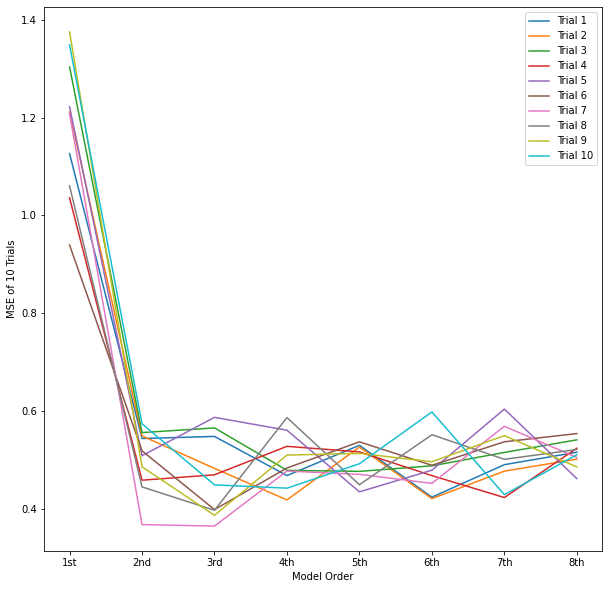

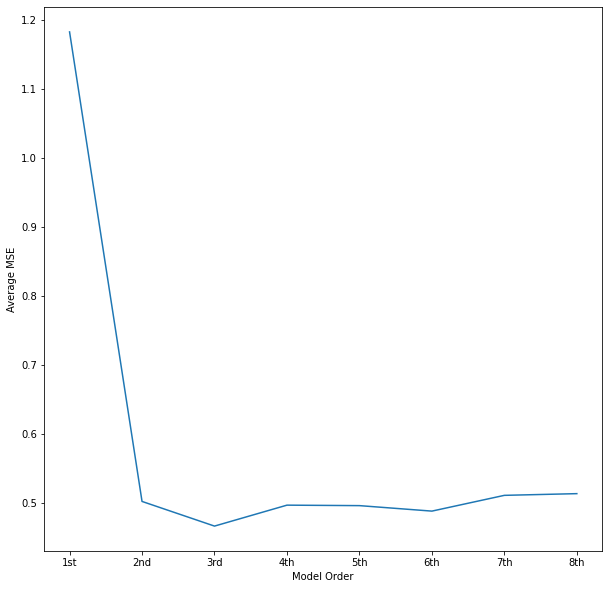

In [ ]:
#STEP 8

#STUDENT CODE - plot validation set spaghetti charts
#---------------------------------------------

plt.figure(figsize=(10,10))
plt.plot(cv)
plt.xlabel("Model Order")
plt.ylabel("MSE of 10 Trials")
plt.legend(labels=COLUMNS )
plt.show()
y = cv.mean(axis=1)
plt.figure(figsize=(10,10))
plt.plot(y)
plt.xlabel("Model Order")
plt.ylabel("Average MSE")
plt.show()

#---------------------------------------------

STEP_8_COMPLETE = False

#### Leave-One-Out Cross-Validation


##### STEP 9: loocv rmse

In this step, you'll create loocv_mse(X, y, random_state) which returns the average root mean squared error of models fit to training sets and evaluated on the validation sets as defined by the Leave-One-Out Cross Validation approach.

- X is a DataFrame of feature inputs
- y is a Series of targets
- return a scalar value representing the root mean squared error

Hints:
- See hints in STEP 6 for guidance here
- One caveat to consider... what is the type/shape of the value returned by the `cross_val_score` method in STEP 6? What is it here? Another way to think about this question is how many models are being evaluated in the Validation Set approach (STEP 6)? How many models are being evaluted in LOOVC? If your function is expected to return a single RMSE, what will you do differently, here?
- Your code will likely look nearly identical to that in STEP 6. Don't worry about avoiding repeatition... in practice, you will rarely implement more than one method of cross-validation in your research. Therefore, it's reasonable to generate the full workflow here as a possible source for your research later  (apart from reuse of constants from the SETUP B step above).

In [ ]:
#STEP 9

#STUDENT CODE - create loocv_mse(X, y, random_state)
#---------------------------------------------

#---------------------------------------------

STEP_9_COMPLETE = False

##### STEP 10: dataframe of loocv rmse

In this step, you'll generate a DataFrame of RMSE values for 1 trial of 8 models using the Leave One Out Cross-Validation approach. As in STEP 7, each model will represent an increasing order polynomial feature set. For example, the first value in the DataFrame for Trial 1 will be the the RMSE for a 1st order $(x^1)$ model, whereas the eighth value will be the MSE for an 8th order $(x^1, x^2, ... , x^8)$ model.

Hints:
- Unlike STEP 7, you'll have only one column of data representing a single trial of 8 models of polynomials

In [ ]:
#STEP 10

#STUDENT CODE - create DataFrame of LOOCV Order data
#---------------------------------------------

#---------------------------------------------

STEP_10_COMPLETE = True

##### STEP 11: plot loocv

In this step, create a spaghetti plot of LOOVC for each order polynomial model. Be sure to label your axes.

- Your plot might look something like this (specific values will vary):

![loocv spaghetti plot](https://raw.githubusercontent.com/afit-csce623-master/template-hw3/main/images/loocv_spaghetti.png)

In [ ]:
#STEP 11

#STUDENT CODE - plot loocv spaghetti chart
#---------------------------------------------

#---------------------------------------------

STEP_11_COMPLETE = False

#### k-Fold Cross Validation

##### STEP 12: kfold rmse

In this step, you'll create kfold_mse(X, y, k, random_state) which returns the average root mean squared error of models fit to training sets and evaluated on the validation sets as defined by the k-fold cross-validation approach.

- `X` is a DataFrame of feature inputs
- `y` is a Series of targets
- `k` is the number of folds 
- return a scalar value representing the root mean squared error

Hints:
- See hints in STEP 6 STEP 9 for guidance here
- Though `cross_val_score` provides a mechanism to pass an integer via the `cv` argument to implement k-fold CV without a cross-validation iterator, this method does not randomize or shuffle the train and validation sets. As you the next step will require that you run multiple trials, do not use the short provided in `cross_val_score` to use k-fold CV. Instead, select the appropriate cross-validation generator with the appropriate `shuffle` and `random_state` values.

In [ ]:
#STEP 12

#STUDENT CODE - create kfold_mse(X, y, k, random_state)
#---------------------------------------------

#---------------------------------------------

STEP_12_COMPLETE = False

##### STEP 13: dataframe of kfold rmse

In this step, you'll generate a DataFrame of RMSE values for 10 trials of 8 models using the 10-fold cross-validation approach.

In [ ]:
#STEP 13

#STUDENT CODE - create DataFrame of LOOCV Order data
#---------------------------------------------

#---------------------------------------------

STEP_13_COMPLETE = True

##### STEP 14: plot kfold rmse

In this step, create a spaghetti plot of the k-fold trials. Be sure to label your axes.

- Your plot might look something like this (specific values will vary):

![kfold spaghetti plot](https://raw.githubusercontent.com/afit-csce623-master/template-hw3/main/images/kfold_spaghetti.png)

In [ ]:
#STEP 14

#STUDENT CODE - plot k-fold spaghetti charts
#---------------------------------------------

#---------------------------------------------

STEP_14_COMPLETE = False

#### Discussion

##### STEP 15: analysis

Review the spaghetti charts created in STEPS 8, 11, and 14, then answer the following questions.

- For both the Validation Set and for k-fold approaches we conducted 10 trials, and there was variation between them. What would have occurred had we conducted 10 trials of LOOCV?

  <font color=green class="student_answer">Student Discussion</font>


- Which cross-validation approach has the greatest variation from one trial to the next? Why?

  <font color=green class="student_answer">Student Discussion</font>

- Which cross-validation approach has the least variation from one trial to the next? Why?

  <font color=green class="student_answer">Student Discussion</font>

- Suppose you had observations whose targets (y-values) range from $[0-10]$. When you conduct cross-validation, you note that the model of polynomial order $p$ yields an RMSE of 0.0800, but the model of polynomial order $p+4$ yields an RMSE of 0.0792. In terms of $p$, which model will you use and why?

  <font color=green class="student_answer">Student Discussion</font>

- Which CV approach do you think will be most appropriate for your machine learning research? Why?

  <font color=green class="student_answer">Student Discussion</font>



In [ ]:
STEP_15_COMPLETE = False

##### STEP 16: model selection

Based on your analysis of cross-validation, which order polynomial model will you choose? Why?

  <font color=green class="student_answer">Student Discussion</font>


In [ ]:
STEP_16_COMPLETE = False

#### Model Creation & Evaluation

##### STEP 17: Model Creation

In this step, you will generate a model of the polynomial order you identified in STEP 16 (using your `poly_df` function). Then, you will fit that model to your data.

Finally, you'll plot your model, along with the original data and your initial guess. Be sure to label your plot. Here is an example of a possible result:

![fit model plot](https://raw.githubusercontent.com/afit-csce623-master/template-hw3/main/images/plot_fit_overlay2.png)

In [ ]:
#STEP 17

#STUDENT CODE - fit model, plot initial guess and best fit line
#---------------------------------------------

#---------------------------------------------

STEP_17_COMPLETE = False

##### STEP 18: Model Evaluation

In this step, you will generate test data and evaluate the performance of your fitted model on that test data.

Hints:
- To generate test data, you will use the `generate_data()` function. It is critical you reuse the seed value that you used in STEP 2. Using a different seed value will result in you creating test data generated from a different data signal, and your model will inevitably perform disastrously. Also, you will need to set the optional argument `test_data` to `True`:

  `df_test = generate_data(seed, test_data=True)`

  You should use the actual value of `seed` unless you are ABSOLUTELY sure that you have not modified it somewhere in the notebook

- After you have generated the data, be sure that you engineer a feature set of the appropriate polynomial order.

- Page 80 of _HOML_ provides an example of how you can calculate the RMSE of your model on test data. Note that the text calculates the square root of the mean squared error. If you take a look at the [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) function, you'll see that you can set an argument to return the RMSE, without a need to take a square root of the result.

- Note that the instructor solution for this step involves approximately 5 steps. If you are using significantly more than that, you may not be effectively using the functions you've created or the scikit-learn tools.

In [ ]:
#STEP 18

#STUDENT CODE - generate test data, calculate rmse on test data
#---------------------------------------------

#---------------------------------------------

STEP_18_COMPLETE = False

#### STEP 19: final model discussion

Answer the following questions

- What is your model's performance on test data?

  <font color=green class="student_answer">Student Discussion</font>


- How does this compare to the cross-validation error that you used to determine the polynomial order for your model?

  <font color=green class="student_answer">Student Discussion</font>

- What accounts for the difference between the cross-validation error and the error on the test data?

  <font color=green class="student_answer">Student Discussion</font>

- What is the most appropriate metric to use when advertising the performance of your model?

  <font color=green class="student_answer">Student Discussion</font>



In [ ]:
STEP_19_COMPLETE = False

In [ ]:
# Enter the number of hours you spend on this homework assignment as a floating point value

hours_spent = 0.0

STEP_20_COMPLETE = False